## Molecular Fingerprints

using k-Nearest Neighbors model + recursive feature elimination with molecular fingerprints to predict its bandgap!

In [1]:
%matplotlib inline  
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
from tqdm import tqdm
import pandas as pd
import numpy as np
import json

##### uploading QM9 dataset + creating train and test datasets

In [2]:
data = pd.read_json('../datasets/qm9.json.gz', lines=True)
train_data, test_data = train_test_split(data, train_size=1000, test_size=2000)

#### Defining classes to compute and transform fingerprints

In [3]:
def compute_morgan_fingerprints(smiles: str, fingerprint_length: int, fingerprint_radius: int):
    """Get Morgan Fingerprint of a specific SMILES string.
    Adapted from: <https://github.com/google-research/google-research/blob/
    dfac4178ccf521e8d6eae45f7b0a33a6a5b691ee/mol_dqn/chemgraph/dqn/deep_q_networks.py#L750>
    Args:
      graph (str): The molecule as a SMILES string
      fingerprint_length (int): Bit-length of fingerprint
      fingerprint_radius (int): Radius used to compute fingerprint
    Returns:
      np.array. shape = [hparams, fingerprint_length]. The Morgan fingerprint.
    """
    # Parse the molecule
    molecule = Chem.MolFromSmiles(smiles)

    # Compute the fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        molecule, fingerprint_radius, fingerprint_length)
    arr = np.zeros((1,), dtype=bool)

    # ConvertToNumpyArray takes ~ 0.19 ms, while
    # np.asarray takes ~ 4.69 ms
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr

In [4]:
class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    """Class that converts SMILES strings to fingerprint vectors"""
    
    def __init__(self, length: int = 256, radius: int = 4):
        self.length = length
        self.radius = radius
    
    def fit(self, X, y=None):
        return self  # Do need to do anything
    
    def transform(self, X, y=None):
        """Compute the fingerprints
        
        Args:
            X: List of SMILES strings
        Returns:
            Array of fingerprints
        """
        
        fing = [compute_morgan_fingerprints(m, self.length, self.radius) for m in X]
        return np.vstack(fing)

##### Setting fingerprint length of 128 bits and radius of 3 (determines the scope of the chemical interactions of each atom)

In [5]:
m = MorganFingerprintTransformer(4, 4)
m.length = 128
m.radius = 3

In [6]:
test_fng = m.transform(test_data['smiles_0']) # transforming train and test datasets into Morgan fingerprints
train_fng = m.transform(train_data['smiles_0'])

#### Plotting a learning curve to analyze the relationship between the number of neighbors and mean absolute error!

In [7]:
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_absolute_error

results = []

for n in tqdm([1, 2, 4, 8, 16, 32, 64, 128]):  # loop over different training set sizes
    for i in range(16):  # repeat the experiment

            # train and test the model
            krr = KNeighborsRegressor(n_neighbors = n, metric='jaccard')
            knn = krr.fit(train_fng, train_data['bandgap'])
            y_pred = knn.predict(test_fng)

            results.append({
                'n_neighbors': n,
                'iteration': i,
                'r2_score': r2_score(test_data['bandgap'], y_pred),
                'mae': mean_absolute_error(test_data['bandgap'], y_pred)
            })
results = pd.DataFrame(results)  # Converts to a dataframe

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:14<00:00, 16.76s/it]


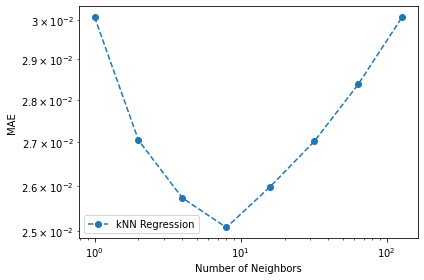

In [8]:
fig, ax = plt.subplots()

group_stats = results.groupby('n_neighbors').mean()
    
ax.loglog(group_stats.index, group_stats['mae'], '--o', label=f'kNN Regression')
    
ax.legend()

ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('MAE')
fig.tight_layout()

#### Adding recursive feature elimination to k-Nearest Neighbors model + plotting another learning curve!

In [9]:
from sklearn.feature_selection import RFE 
from sklearn.ensemble import RandomForestRegressor

In [10]:
model = Pipeline([ # condensing all steps into a pipeline for easier training
    ('fingerprint', MorganFingerprintTransformer()),
    ('rfe_method', RFE(estimator=RandomForestRegressor(), n_features_to_select=32, step=4)),
    ('knn', KNeighborsRegressor(metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
])

In [12]:
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_absolute_error

results = []

for n in tqdm([1, 2, 4, 8, 16, 32, 64, 128]):  # ;oop over different training set sizes
    for i in range(16):  # repeat the experiment
            model.set_params(knn__n_neighbors=n)
            # train and test the model
            model.fit(train_data['smiles_0'], train_data['bandgap'])
            y_pred = model.predict(test_data['smiles_0'])

            results.append({
                'n_neighbors': n,
                'iteration': i,
                'r2_score': r2_score(test_data['bandgap'], y_pred),
                'mae': mean_absolute_error(test_data['bandgap'], y_pred)
            })
results = pd.DataFrame(results)  # converts to a dataframe

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [2:08:45<00:00, 965.74s/it]


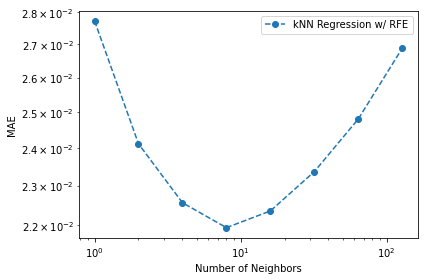

In [13]:
fig, ax = plt.subplots()

group_stats = results.groupby('n_neighbors').mean()
    
ax.loglog(group_stats.index, group_stats['mae'], '--o', label=f'kNN Regression w/ RFE')
    
ax.legend()

ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('MAE')
fig.tight_layout()

### Conclusions: 

1. Adding recursive feature elimination lowers the MAE at the optimized number of neighbors for kNN!

2. Feature selection improved this model because general-purpose distance metrics can be heavily sensitive to outliers, which can drastically skew the data especially considering that this model lacks the ability to identify feature relevance without any future selection. By identifying particular data points that represent the dataset more accurately, it reduces the influence of outliers, thus improving the model's accuracy. 